In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [3]:
df = pd.read_csv('/kaggle/input/dataset/data.csv')
df = df.dropna() 

In [4]:
scalers = {}
columns_to_scale = [
    'cadle-size', 'Upper_Shadow', 'Lower_Shadow', 'RSI', 'ATR', 
    'BB_upper', 'BB_middle', 'BB_lower', 'Future_Close', 'Price_Change', 'Delta_Price'
]

In [5]:
features = [
    'Delta_Price', 'Grap', 'cadle-size', 'Upper_Shadow', 'Lower_Shadow', 
    'RSI', 'ATR', 'BB_upper', 'BB_middle', 'BB_lower', 'Future_Close', 'Price_Change'
]
target = 'Direction'


In [6]:
seq_len = 14
data = df[features + [target]].values
sequences = []

for i in range(len(data) - seq_len):
    sequences.append(data[i:i + seq_len])

sequences = np.array(sequences)
X = sequences[:, :-1, :-1] 
y_direction = sequences[:, -1, -1]

# split data

In [7]:
train_size = int(0.8 * len(X))
valid_size = int(0.1 * len(X))
test_size = len(X) - train_size - valid_size

X_train, y_direction_train = X[:train_size], y_direction[:train_size]
X_valid, y_direction_valid = X[train_size:train_size + valid_size], y_direction[train_size:train_size + valid_size]
X_test, y_direction_test = X[train_size + valid_size:], y_direction[train_size + valid_size:]

# convert to tensor

In [8]:
X_train = torch.tensor(X_train, dtype=torch.float32)
y_direction_train = torch.tensor(y_direction_train, dtype=torch.long)
X_valid = torch.tensor(X_valid, dtype=torch.float32)
y_direction_valid = torch.tensor(y_direction_valid, dtype=torch.long)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_direction_test = torch.tensor(y_direction_test, dtype=torch.long)

# Creat  TensorDataset and DataLoader

In [9]:
train_dataset = TensorDataset(X_train, y_direction_train)
valid_dataset = TensorDataset(X_valid, y_direction_valid)
test_dataset = TensorDataset(X_test, y_direction_test)

train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=32, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)


# train model

In [10]:
class NeuralNetwork(nn.Module):
    def __init__(self, num_feature, hidden_size=64, dropout_rate=0.5):
        super(NeuralNetwork, self).__init__()
        self.lstm = nn.LSTM(input_size=num_feature, hidden_size=hidden_size, batch_first=True)
        self.dropout = nn.Dropout(p=dropout_rate)
        self.fc_direction = nn.Linear(hidden_size, 2) 

    def forward(self, x):
        _, (hidden, _) = self.lstm(x)
        hidden = self.dropout(hidden[-1])
        direction = self.fc_direction(hidden)
        return direction


In [11]:
num_features = len(features)
model = NeuralNetwork(num_feature=num_features).to(device)

optimizer = optim.Adam(model.parameters(), lr=1e-3)
ce_loss = nn.CrossEntropyLoss()

In [12]:
def train(dataloader):
    model.train()
    epoch_loss = 0
    for x, y_direction in dataloader:
        x, y_direction = x.to(device), y_direction.to(device)

        optimizer.zero_grad()
        pred_direction = model(x)
        loss = ce_loss(pred_direction, y_direction)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    return epoch_loss / len(dataloader)

def evaluate(dataloader):
    model.eval()
    epoch_loss = 0
    with torch.no_grad():
        for x, y_direction in dataloader:
            x, y_direction = x.to(device), y_direction.to(device)
            pred_direction = model(x)
            loss = ce_loss(pred_direction, y_direction)
            epoch_loss += loss.item()
    return epoch_loss / len(dataloader)


In [13]:
def calculate_accuracy(dataloader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for x, y_direction in dataloader:
            x, y_direction = x.to(device), y_direction.to(device)
            pred_direction = model(x)
            predicted = torch.argmax(pred_direction, dim=1)
            correct += (predicted == y_direction).sum().item()
            total += y_direction.size(0)
    return correct / total

In [14]:
n_epochs = 50
train_losses = []
valid_losses = []
best_valid_loss = float('inf')

for epoch in range(1, n_epochs + 1):
    train_loss = train(train_dataloader)
    valid_loss = evaluate(valid_dataloader)
    valid_accuracy = calculate_accuracy(valid_dataloader)

    train_losses.append(train_loss)
    valid_losses.append(valid_loss)

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'best_model.pt')

    print(f'Epoch {epoch:02} | Train Loss: {train_loss:.4f} | Val Loss: {valid_loss:.4f} | Val Accuracy: {valid_accuracy:.2%}')


Epoch 01 | Train Loss: 0.6009 | Val Loss: 0.5422 | Val Accuracy: 74.77%
Epoch 02 | Train Loss: 0.5420 | Val Loss: 0.5458 | Val Accuracy: 71.71%
Epoch 03 | Train Loss: 0.5292 | Val Loss: 0.5026 | Val Accuracy: 75.17%
Epoch 04 | Train Loss: 0.5229 | Val Loss: 0.5394 | Val Accuracy: 76.40%
Epoch 05 | Train Loss: 0.5160 | Val Loss: 0.5081 | Val Accuracy: 76.44%
Epoch 06 | Train Loss: 0.5090 | Val Loss: 0.5305 | Val Accuracy: 75.40%
Epoch 07 | Train Loss: 0.5020 | Val Loss: 0.5253 | Val Accuracy: 73.18%
Epoch 08 | Train Loss: 0.4950 | Val Loss: 0.4840 | Val Accuracy: 76.57%
Epoch 09 | Train Loss: 0.4910 | Val Loss: 0.4894 | Val Accuracy: 75.43%
Epoch 10 | Train Loss: 0.4888 | Val Loss: 0.4703 | Val Accuracy: 77.83%
Epoch 11 | Train Loss: 0.4861 | Val Loss: 0.4797 | Val Accuracy: 75.62%
Epoch 12 | Train Loss: 0.4823 | Val Loss: 0.4559 | Val Accuracy: 78.29%
Epoch 13 | Train Loss: 0.4803 | Val Loss: 0.4684 | Val Accuracy: 79.07%
Epoch 14 | Train Loss: 0.4762 | Val Loss: 0.4553 | Val Accuracy:

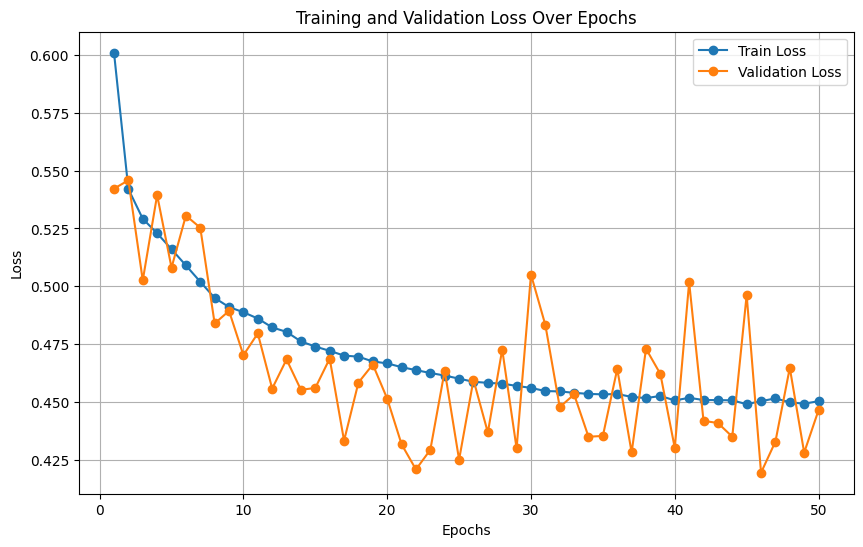

In [15]:
plt.figure(figsize=(10, 6))
plt.plot(range(1, n_epochs + 1), train_losses, label='Train Loss', marker='o')
plt.plot(range(1, n_epochs + 1), valid_losses, label='Validation Loss', marker='o')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.grid()
plt.show()


# predict

In [16]:
model.load_state_dict(torch.load('best_model.pt'))
model.eval()

/tmp/ipykernel_23/1812604575.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model.pt'))


NeuralNetwork(
  (lstm): LSTM(12, 64, batch_first=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc_direction): Linear(in_features=64, out_features=2, bias=True)
)

In [17]:
def predict_and_compare(model, dataloader):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for x, y_direction in dataloader:
            x, y_direction = x.to(device), y_direction.to(device)

            pred_direction = model(x)
            predicted_classes = torch.argmax(pred_direction, dim=1)

            all_preds.extend(predicted_classes.cpu().numpy())
            all_labels.extend(y_direction.cpu().numpy())

    return np.array(all_preds), np.array(all_labels)

In [18]:
test_preds, test_labels = predict_and_compare(model, test_dataloader)

comparison_df = pd.DataFrame({'Actual': test_labels, 'Predicted': test_preds})
print(comparison_df.head(20)) 

    Actual  Predicted
0        0          0
1        0          0
2        1          0
3        0          0
4        0          0
5        0          0
6        0          0
7        0          0
8        0          0
9        0          0
10       1          0
11       1          0
12       1          1
13       1          1
14       1          1
15       0          1
16       0          1
17       1          0
18       1          0
19       1          1


In [19]:
correct_predictions = (test_preds == test_labels).sum()
total_predictions = len(test_labels)
accuracy = correct_predictions / total_predictions * 100
print(f'Accuracy on Test Set: {accuracy:.2f}%')

Accuracy on Test Set: 80.99%


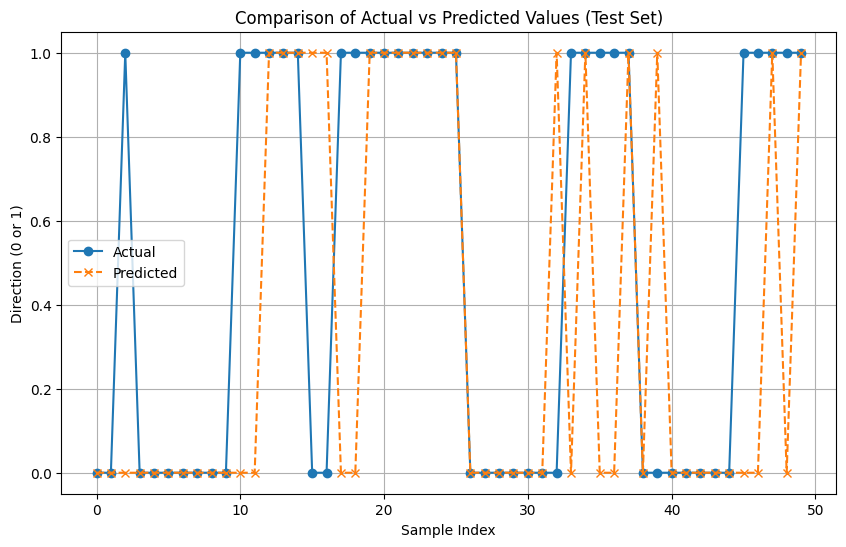

In [20]:
plt.figure(figsize=(10, 6))
plt.plot(test_labels[:50], label='Actual', marker='o', linestyle='-')  # Hiển thị 50 mẫu đầu tiên
plt.plot(test_preds[:50], label='Predicted', marker='x', linestyle='--')
plt.title('Comparison of Actual vs Predicted Values (Test Set)')
plt.xlabel('Sample Index')
plt.ylabel('Direction (0 or 1)')
plt.legend()
plt.grid()
plt.show()